In [1]:
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

cmap = matplotlib.colormaps['cool']

# Nonparametric Bayes Factor Code (Adopted from Ziqi Mu)

In [2]:
from scipy.stats import norm as scipy_norm

def get_bayes_factor(data_1, data_2, c = 1, max_depth=6, aj=lambda depth: depth**2, log_BF=False, scale_method = 'iqr'):
    """
    nonparamteric Bayes factors

    parameters:

    data_1 : arraylike
        Numpy array of data points sampled from the first distribution
    data_2 : arraylike
        Numpy array of data points sampled from the second distribution
    c : int 
        The tunable paramter c descibed in https://arxiv.org/abs/0910.5060v3
    max_depth : int
        The maximum depth of the partially specified Polya tree as described in https://arxiv.org/abs/0910.5060v3
        The Polya tree has a tree height of max_depth.
    aj : function
        The prescription for calculateing aj terms as a function of tree depth 
        as described in https://arxiv.org/abs/0910.5060v3
    log_BF: bool
        When False, the Bayes factor is returned, and when True, log10(Bayes factor) is returned
    """

    # normalize the input data
    data_1, data_2 = scale_data(data_1, data_2, scale_method)
    data_switch = len(data_1)
    combined_data = np.concatenate([data_1, data_2])
    del data_1, data_2

    # partition the data into quartiles
    quantiles = np.quantile(combined_data, np.linspace(0,1,2**max_depth + 1))

    # get the log bayes factor
    logbf = _get_bayes_factor(combined_data, data_switch, quantiles, low=0, high=1, c=c, depth=1, max_depth=max_depth, aj=aj)

    # return either the bayes factor or log bayes factor
    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def _get_bayes_factor(combined_data, data_switch, quantiles, low, high, c, depth, max_depth,aj):
    """
    helper function called by get_bayes_factor

    parameters:

    combined_data : arraylike
        Numpy array of data points sampled from the first and second distributions. 
        Data from the second distribution should follow after data from the first
    data_switch : int
        The array index seperating the two sampled distributions in combined_data
    low : float
        The low quantile for the current Polya tree node
    high : float
        The high quantile for the current Polya tree node
    c : int 
        The tunable paramter c descibed in https://arxiv.org/abs/0910.5060v3
    depth : int
        The depth of the current node in the Polya tree
    max_depth : int
        The maximum depth of the partially specified Polya tree as described in https://arxiv.org/abs/0910.5060v3
    aj : function
        The prescription for calculateing aj terms as a function of tree depth 
        as described in https://arxiv.org/abs/0910.5060v3
    
    """
    
    if depth > max_depth: 
        return 0

    # seelct quartiles
    low_q = quantiles[int((2**max_depth ) * low)]
    mid_q = quantiles[int((2**max_depth ) * (low+high)/2)]
    high_q = quantiles[int((2**max_depth ) * high)]

    # count data in quartiles
    if high == 1:
        data_1_low = np.count_nonzero((combined_data[:data_switch]>=low_q)*(combined_data[:data_switch]<=mid_q))
        data_2_low = np.count_nonzero((combined_data[data_switch:]>=low_q)*(combined_data[data_switch:]<=mid_q))
        data_1_high = np.count_nonzero((combined_data[:data_switch]>=mid_q)*(combined_data[:data_switch]<=high_q))
        data_2_high = np.count_nonzero((combined_data[data_switch:]>=mid_q)*(combined_data[data_switch:]<=high_q))
    else:
        data_1_low = np.count_nonzero((combined_data[:data_switch]>=low_q)*(combined_data[:data_switch]<mid_q))
        data_2_low = np.count_nonzero((combined_data[data_switch:]>=low_q)*(combined_data[data_switch:]<mid_q))
        data_1_high = np.count_nonzero((combined_data[:data_switch]>=mid_q)*(combined_data[:data_switch]<high_q))
        data_2_high = np.count_nonzero((combined_data[data_switch:]>=mid_q)*(combined_data[data_switch:]<high_q))

    # calculate the n_j terms for the current binnings
    data_1_n_j = [data_1_low, data_1_high]
    data_2_n_j = [data_2_low, data_2_high]

    # truncate the tree where there is no data
    if np.sum(data_1_n_j) == 0 or np.sum(data_2_n_j) == 0:
        return 0

    # calculate the a_j term for the current tree depth
    a_j = c * aj(depth)

    # calculate b_j

    log_gamma_summand_1 = 2 * gammaln(a_j) - gammaln(2 * a_j)
    log_gamma_summand_2 = gammaln(a_j + data_1_n_j[0] + data_2_n_j[0]) + gammaln(a_j + data_1_n_j[1] + data_2_n_j[1]) 
    log_gamma_summand_3 = - gammaln(2*a_j + data_1_n_j[0] + data_2_n_j[0] + data_1_n_j[1] + data_2_n_j[1])
    log_gamma_summand_4 = gammaln(2*a_j + data_1_n_j[0] + data_1_n_j[1]) + gammaln(2*a_j + data_2_n_j[0] + data_2_n_j[1])
    log_gamma_summand_5 = - gammaln(a_j + data_1_n_j[0]) - gammaln(a_j + data_2_n_j[0]) - gammaln(a_j + data_1_n_j[1]) - gammaln(a_j + data_2_n_j[1])

    log_b_j = log_gamma_summand_1 + log_gamma_summand_2 + log_gamma_summand_3 + log_gamma_summand_4 + log_gamma_summand_5

    # calculate the product of b_j terms on the left partition of the tree
    log_left_tree_b_j = _get_bayes_factor(combined_data, data_switch, quantiles, low, (low+high)/2, c, depth+1, max_depth, aj)

    # calculate the product of b_j terms on the right partition of the tree
    log_right_tree_b_j = _get_bayes_factor(combined_data, data_switch, quantiles, (low+high)/2, high, c, depth+1, max_depth, aj)

    # calculate the product of the b_j terms
    summed_b_j = log_b_j + log_left_tree_b_j + log_right_tree_b_j

    return summed_b_j

def scale_data(data_1, data_2, scale_method):
    """
    Normalize the data according to a particular method
    mad = median and median average deviation
    iqr = median and interquartile range
    std = mean and standard deviation

    """
    data = np.concatenate((data_1, data_2))
    if scale_method == 'mad':
        mad = np.median(np.absolute(data - np.median(data)))
        return (data_1 - np.median(data)) / mad, (data_2 - np.median(data)) / mad
    elif scale_method == 'iqr':
        iqr = np.diff(np.quantile(data,[.25,.75]))
        return (data_1 - np.median(data)) / iqr, (data_2 - np.median(data)) / iqr
    elif scale_method == 'std':
        return (data_1 - np.mean(data)) / np.std(data), (data_2 - np.mean(data)) / np.std(data)      #standardize

# Parametric Bayes Factor Code (Adopted from Kelly Douglass)

In [4]:
'''
Calculate the Bayes factor for the stellar mass using the pocoMC package to 
determine whether the void and wall samples are drawn from the same or different 
parent distributions.
'''


################################################################################
# Import modules
#-------------------------------------------------------------------------------
from astropy.table import Table
from astropy.io import fits
from scipy.stats import norm, uniform

import numpy as np

import sys

import os
os.environ['OMP_NUM_THREADS'] = '1'

import pocomc as pc

from multiprocessing import Pool

import pickle
import corner

def log_prior(params, bounds):
    '''
    Log-prior probability density function used by either data set and either 
    model.


    PARAMETERS
    ==========

    params : ndarray of shape (n,)
        Array of parameter values.
        
    bounds : ndarray of shape (n,2)
        Array of parameter bounds.


    RETURNS
    =======
    
    -np.inf if any parameter falls outside of its limits, 0 otherwise.
    '''

    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0





################################################################################
#-------------------------------------------------------------------------------
def logLjoint1_norm(params, m, n, x, peaks):
    """
    Joint log-likelihood of the two data sets.
    

    Parameters
    ----------
    params : list or ndarray
        List of 9 parameters: 2x4 skew normal pars + scale factor.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
    peaks : integer
        Number of peaks (skew normals) in the model.
        

    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """

    pars = params
    
    if peaks == 1:
        lambda1 = model_norm(pars, x)
    elif peaks == 2:
        lambda1 = model_norm(pars[:3], x) + model_norm(pars[3:], x)
        """
        elif peaks == 3:
            lambda1 = mixturemodel3_skew(pars, x)
        """
    else:
        print('The mixture model for this many skew normals is not yet defined.')
        exit()

    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    
    lambda2 = lambda1
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + \
                  n*np.log(lambda2) - lambda2 - gammaln(n+1))

def logLjoint2_norm(params, m, n, x, peaks):
    """Joint log-likelihood of the two data sets.
    
    Parameters
    ----------
    params : list or ndarray
        List of 16 parameters: 2x4x2 Gaussian components.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
        
    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """

    if peaks == 1:
        lambda1 = model_norm(params[:3], x)
        lambda2 = model_norm(params[3:], x)
    elif peaks == 2:
        lambda1 = model_norm(params[:3], x) + model_norm(params[3:6], x)
        lambda2 = model_norm(params[6:9], x) + model_norm(params[9:], x)
        """
        elif peaks == 3:
            lambda1 = mixturemodel3_skew(params[:12], x)
            lambda2 = mixturemodel3_skew(params[12:], x)
            """
    else:
        print('The mixture model for this many skew normals is not yet defined.')
        exit()

    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    lambda2[lambda2<=0] = np.finfo(dtype=np.float64).tiny
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + \
                  n*np.log(lambda2) - lambda2 - gammaln(n+1))
################################################################################

def model_norm(params, x):
    """
    One skew normal distribution
    

    Parameters
    ----------

    params : list or ndarray
        List of parameters (expect 1x3).

    x : float or ndarray
        Values to calculate the model.
    

    Returns
    -------
    model : float or ndarray
        Model evaluated at x.
    """

    a, mu, sg = params

    return a*norm.pdf(x,  loc=mu, scale=sg)


################################################################################



################################################################################
# General parameters and properties
#-------------------------------------------------------------------------------

# Parameter labels
"""labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 
                   'b', r'$\mu_b$', r'$\sigma_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 
              '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 
              '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 
              '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$']
              """
labels1_u = ['a', r'$\mu_a$', r'$\sigma_a$']
labels2_u = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 
              '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 
              ]

labels1_bi = ['a', r'$\mu_a$', r'$\sigma_a$', 'b', r'$\mu_b$', r'$\sigma_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 
              '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 
              '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 
              '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 
              ]
# Number of particles to use
n_particles = 1000

# Number of parameters in M1
n_dim1 = len(labels1_u)
n_dim1_bi = len(labels1_bi)

# Number of parameters in M2
n_dim2 = len(labels2_u)
n_dim2_bi = len(labels2_bi)

# Number of CPUs
n_cpus = 10

# Calculation of Parametric and Nonparametric Bayes Factors

## Unimodal Distribution

In [5]:
np.random.seed(0)
population_1 = np.random.normal (loc = 0, scale = 1, size=60000)
population_2 = np.random.normal (loc = -.1, scale = 1, size=60000)

In [6]:
# Bins of data
bins = np.linspace(-4,4,100)
x = (bins[:-1] + bins[1:])/2
n1 = np.histogram(population_1, bins = bins)[0]
dn1 = np.sqrt(n1)
n2 = np.histogram(population_2, bins = bins)[0]
dn2 = np.sqrt(n2)

In [7]:
#-------------------------------------------------------------------------------
# 1-parent model
#-------------------------------------------------------------------------------
fit_bounds1 = [
                  [2000, 6000],  # a ........ Gaussian a amplitude
                  [-1, 1],  # mu_a ..... Gaussian a location
                  [0.5, 1.5],     # sigma_a .. Gaussian a scale
              ]

prior = pc.Prior([
    uniform(x[0], x[1] - x[0]) for x in fit_bounds1
])

# Prior samples for M1
prior_samples1 = np.random.uniform(low=np.array(fit_bounds1).T[0], 
                                      high=np.array(fit_bounds1).T[1], 
                                      size=(n_particles, n_dim1))



with Pool(n_cpus) as pool:

    # Initialize sampler for M1
    sampler1 = pc.Sampler(n_ess=n_particles, 
                             n_dim=n_dim1, 
                             likelihood=logLjoint1_norm, 
                             prior=prior, 
                             #bounds=np.array(fit_bounds1), 
                             likelihood_args=[n1, n2, x, 1], 
                             #prior_args=[np.array(fit_bounds1)], 
                             pool=pool)

    # Run sampler
    sampler1.run()#prior_samples1)
        
# Get results
results1 = sampler1.results


Iter: 62it [07:22,  7.14s/it, calls=26500, beta=1, logZ=-891, ESS=4.92e+3, acc=0.903, steps=2, logP=-886, eff=0.72]           


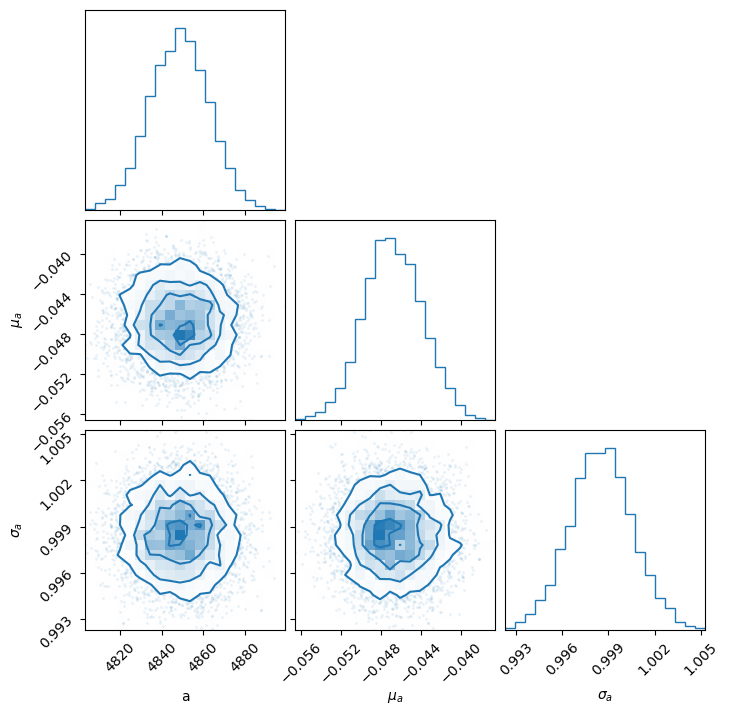

In [8]:

samples1, weights1, logl1, logp1 = sampler1.posterior()

fig = corner.corner(samples1, weights=weights1, labels=labels1_u, color='C0')
plt.show()

In [13]:
# VF log(z)
lnzM1 = results1['logz'][-1]

In [9]:

#-------------------------------------------------------------------------------
# 2-parent model
#-------------------------------------------------------------------------------
fit_bounds2 = [[2000, 6000],  # a ........ Gaussian a amplitude
                [-1, 1],  # mu_a ..... Gaussian a location
                [0.5, 1.5], 
                [2000, 6000],  # a ........ Gaussian a amplitude
                [-1, 1],  # mu_a ..... Gaussian a location
                [0.5, 1.5], 
              ]

prior = pc.Prior([
    uniform(x[0], x[1] - x[0]) for x in fit_bounds2
])

# Prior samples for M2
prior_samples2 = np.random.uniform(low=np.array(fit_bounds2).T[0], 
                                      high=np.array(fit_bounds2).T[1], 
                                      size=(n_particles, n_dim2))



with Pool(n_cpus) as pool:

    # Initialize sampler for M1
    sampler2 = pc.Sampler(n_ess=n_particles, 
                             n_dim=n_dim2, 
                             likelihood=logLjoint2_norm, 
                             prior=prior, 
                             #bounds=np.array(fit_bounds2), 
                             likelihood_args=[n1, n2, x, 1], 
                             #log_prior_args=[np.array(fit_bounds2)], 
                             pool=pool)

    # Run sampler
    sampler2.run()#prior_samples2)
        
# Get results
results2 = sampler2.results

################################################################################



Iter: 82it [07:57,  5.82s/it, calls=38750, beta=1, logZ=-784, ESS=5.05e+3, acc=0.821, steps=2, logP=-775, eff=1]           


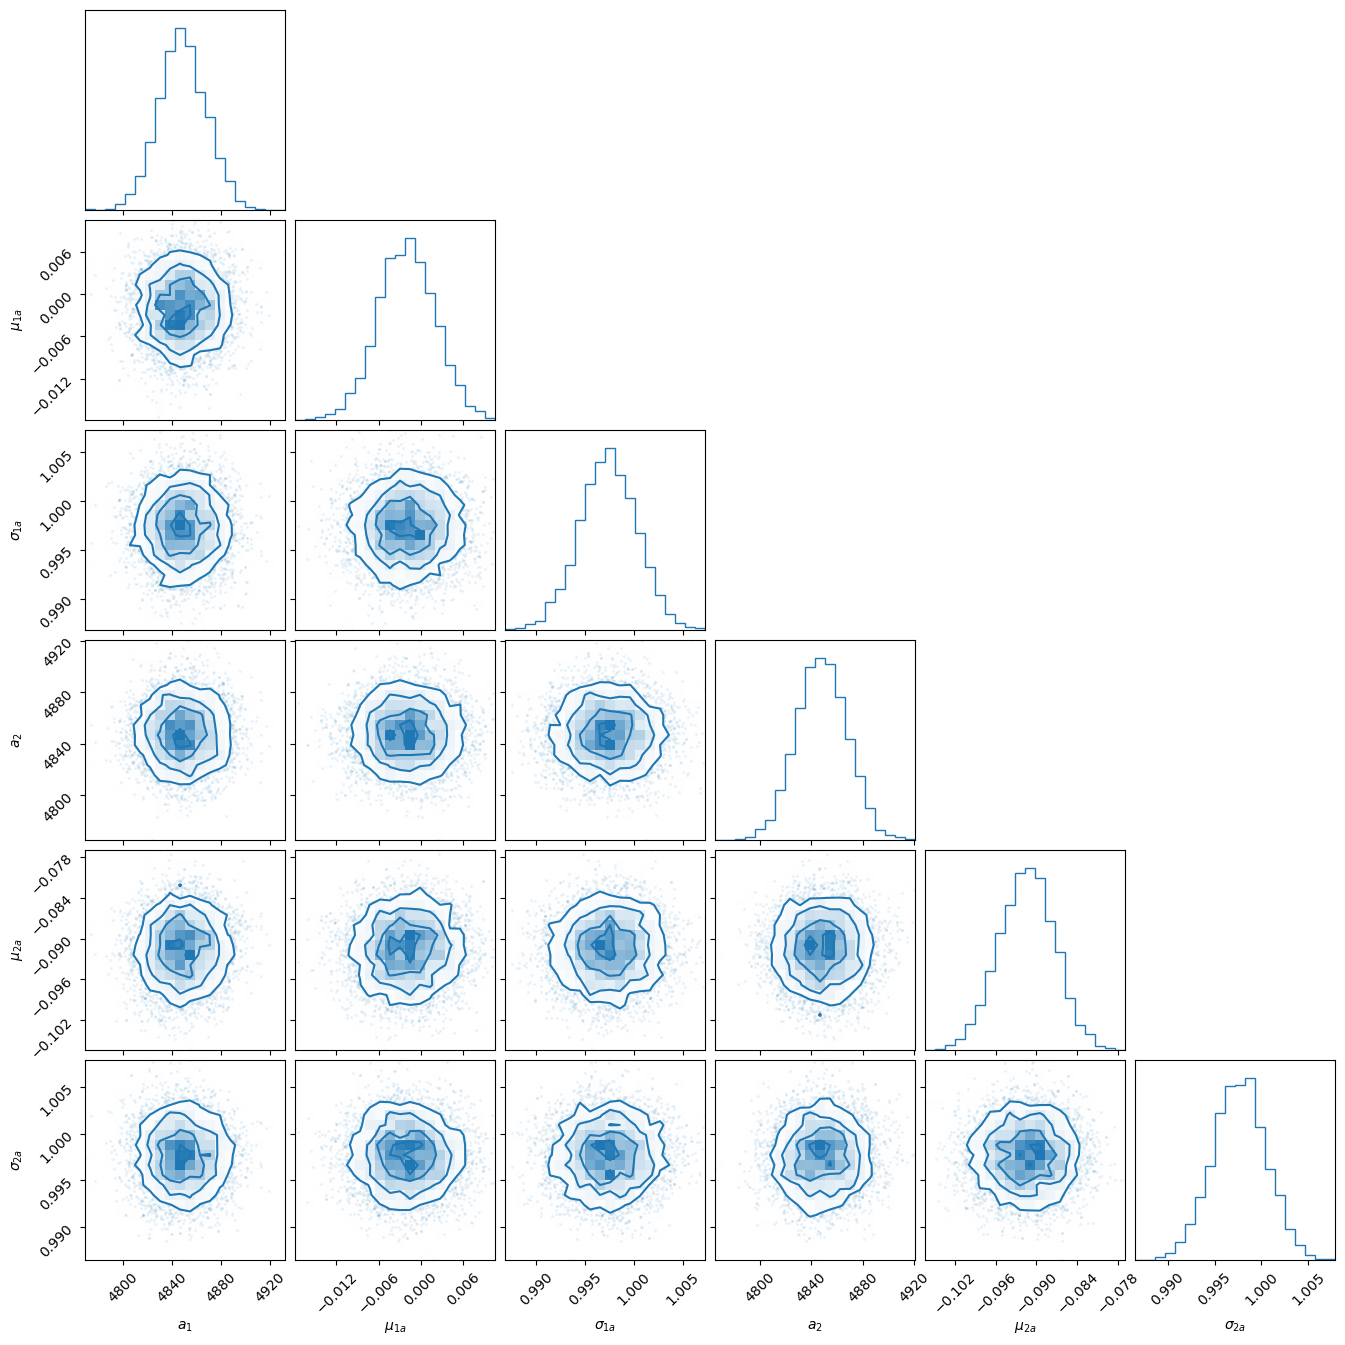

In [10]:

samples2, weights2, logl2, logp2 = sampler2.posterior()

fig = corner.corner(samples2, weights=weights2, labels=labels2_u, color='C0')
plt.show()

In [11]:

# VF log(z)
lnzM2 = results2['logz'][-1]

In [14]:


#-------------------------------------------------------------------------------
# Calculate Bayes factor
#-------------------------------------------------------------------------------
lnB12 = lnzM1 - lnzM2

B12 = np.exp(lnB12)

print('B12 = {:.3g}; log(B12) = {:.3f}'.format(B12, lnB12*np.log10(np.exp(1))))
#-------------------------------------------------------------------------------


B12 = 3.43e-47; log(B12) = -46.464


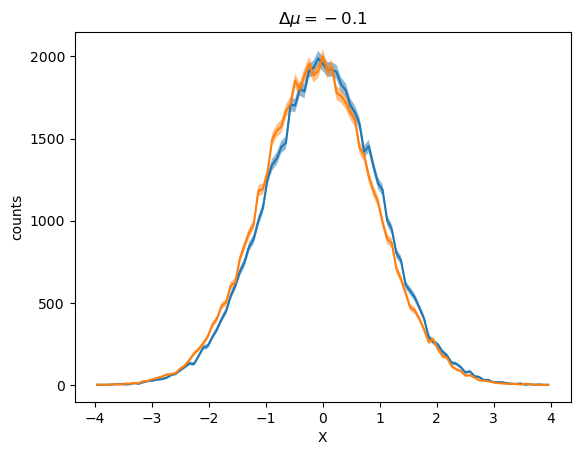

In [15]:
# plot the distributions
plot_x, plot_y = np.histogram(population_1, bins = np.linspace(-4,4,100))[::-1]
plot_x = plot_x[:-1]+np.diff(plot_x)/2
plt.plot(plot_x, plot_y)
plt.fill_between(plot_x, plot_y+np.sqrt(plot_y), plot_y-np.sqrt(plot_y), alpha=.5)

plot_x, plot_y = np.histogram(population_2, bins = np.linspace(-4,4,100))[::-1]
plot_x = plot_x[:-1]+np.diff(plot_x)/2
plt.plot(plot_x, plot_y)
plt.fill_between(plot_x, plot_y+np.sqrt(plot_y), plot_y-np.sqrt(plot_y), alpha=.5)

plt.title('$\Delta \mu = -0.1$')
plt.ylabel('counts')
plt.xlabel('X')

plt.show()


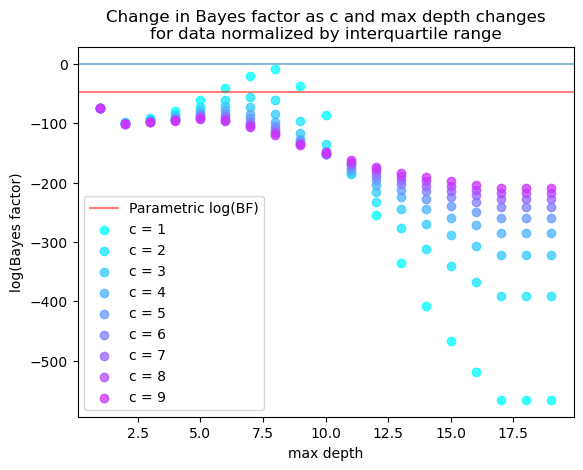

In [16]:
plt.axhline(0,alpha=.5)

plt.axhline(-46.464, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(population_1, population_2, c=c, max_depth=depth, log_BF=True)
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by interquartile range');

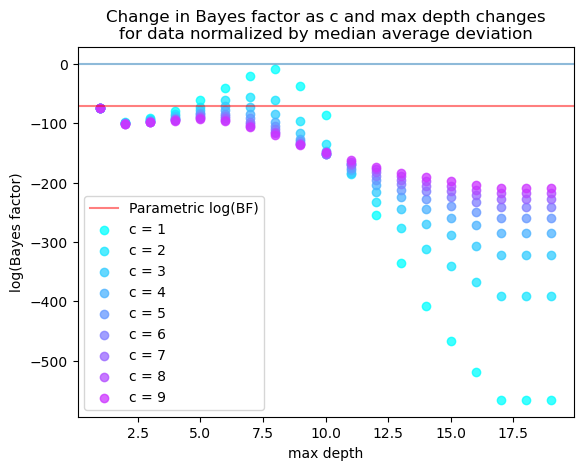

In [17]:
plt.axhline(0,alpha=.5)

plt.axhline(-70.552, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(population_1, population_2, c=c, max_depth=depth, log_BF=True, scale_method='mad')
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by median average deviation');

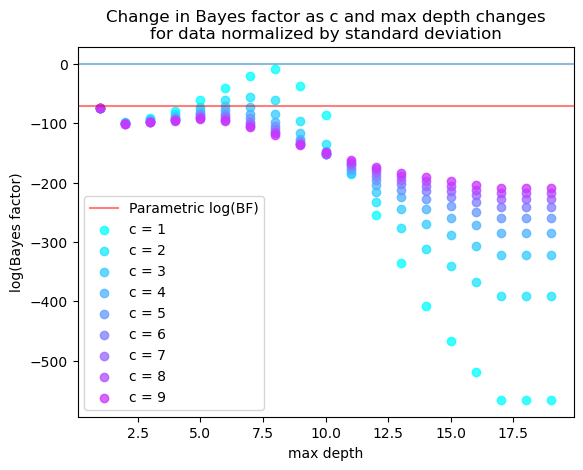

In [18]:
plt.axhline(0,alpha=.5)

plt.axhline(-70.552, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(population_1, population_2, c=c, max_depth=depth, log_BF=True, scale_method='std')
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by standard deviation');

## Bimodal Distribution

In [19]:
def bimodal_data (size, sf_boost = 1):
    # Generate a bimodial normal distribution with `size` points and an adjustment of `sf_boost` to the relative contribution of each normal distribution
    return np.concatenate([(np.random.normal (loc = 1.2, scale = .5, size=int(size*sf_boost))), np.random.normal (loc = -.2, scale = .5, size=int(size/2 - size*(sf_boost - 1)))])


In [20]:
np.random.seed(0)
size=10000
bim_small_1 = bimodal_data(size,1.)
bim_small_2 = bimodal_data(size,1.1)

In [21]:
# Bins of data
bins = np.linspace(-2,3,100)
x = (bins[:-1] + bins[1:])/2
n1 = np.histogram(bim_small_1, bins = bins)[0]
dn1 = np.sqrt(n1)
n2 = np.histogram(bim_small_2, bins = bins)[0]
dn2 = np.sqrt(n2)

In [22]:
#-------------------------------------------------------------------------------
# 1-parent model
#-------------------------------------------------------------------------------
fit_bounds1 = [
                  [100, 400],  # a ........ Gaussian a amplitude
                  [-1, 1],  # mu_a ..... Gaussian a location
                  [0.1, 1.],     # sigma_a .. Gaussian a scale
                  [200, 1000],  # b ........ Gaussian a amplitude
                  [0, 2],  # mu_b ..... Gaussian a location
                  [0.1, 1.],     # sigma_b .. Gaussian a scale
              ]

prior = pc.Prior([
    uniform(x[0], x[1] - x[0]) for x in fit_bounds1
])

# Prior samples for M1
prior_samples1 = np.random.uniform(low=np.array(fit_bounds1).T[0], 
                                      high=np.array(fit_bounds1).T[1], 
                                      size=(n_particles, n_dim1_bi))



with Pool(n_cpus) as pool:

    # Initialize sampler for M1
    sampler1 = pc.Sampler(n_ess=n_particles, 
                             n_dim=n_dim1_bi, 
                             likelihood=logLjoint1_norm, 
                             prior=prior, 
                             #bounds=np.array(fit_bounds1), 
                             likelihood_args=[n1, n2, x, 2], 
                             #prior_args=[np.array(fit_bounds1)], 
                             pool=pool)

    # Run sampler
    sampler1.run()#prior_samples1)
        
# Get results
results1 = sampler1.results


Iter: 74it [07:18,  5.92s/it, calls=41250, beta=1, logZ=-746, ESS=4.94e+3, acc=0.785, steps=4, logP=-735, eff=1]           


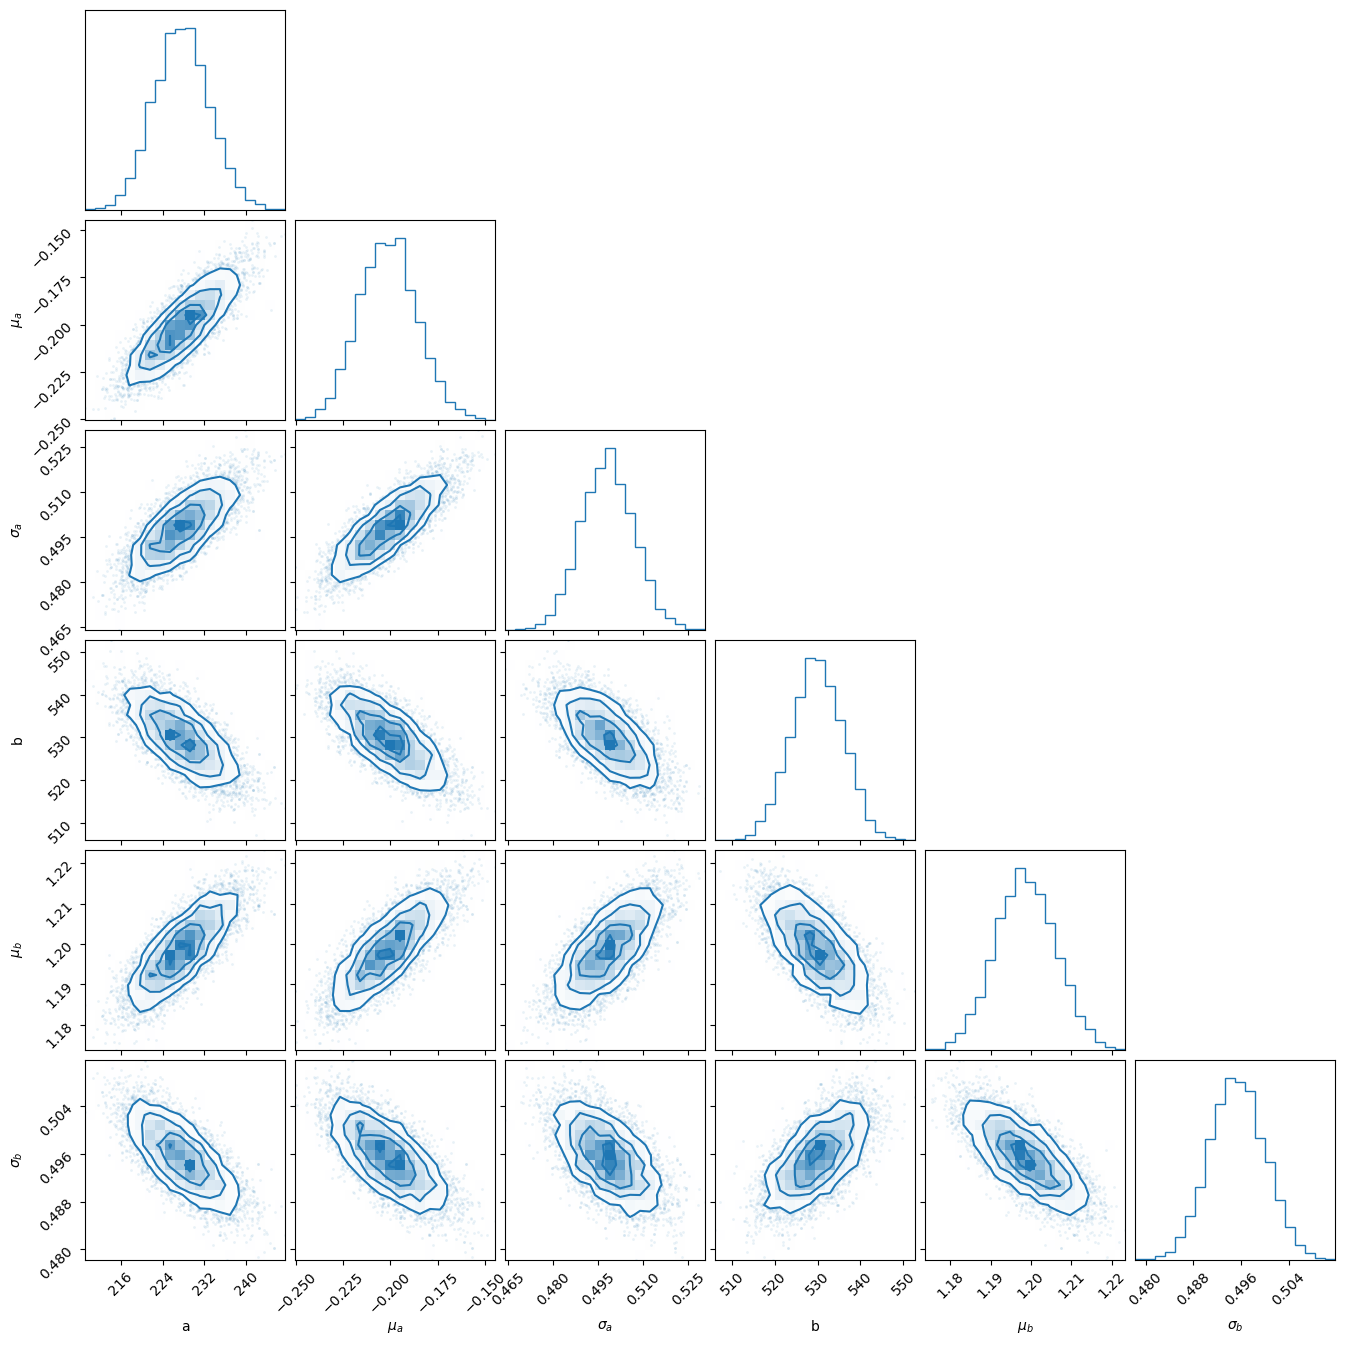

In [23]:

samples1, weights1, logl1, logp1 = sampler1.posterior()

fig = corner.corner(samples1, weights=weights1, labels=labels1_bi, color='C0')
plt.show()

In [107]:
# log(z)
lnzM1 = results1['logz'][-1]

In [ ]:

#-------------------------------------------------------------------------------
# 2-parent model
#-------------------------------------------------------------------------------
fit_bounds2 = [
                  [100, 400],  # a1 ........ Gaussian a amplitude
                  [-1, 1],  # mu_a1 ..... Gaussian a location
                  [0.1, 1.],     # sigma_a1 .. Gaussian a scale
                  [200, 1000],  # b1 ........ Gaussian a amplitude
                  [0, 2],  # mu_b1 ..... Gaussian a location
                  [0.1, 1.],     # sigma_b .. Gaussian a scale
                  [100, 400],  # a2 ........ Gaussian a amplitude
                  [-1, 1],  # mu_a2 ..... Gaussian a location
                  [0.1, 1.],     # sigma_a2 .. Gaussian a scale
                  [200, 1000],  # b2 ........ Gaussian a amplitude
                  [0, 2],  # mu_b2 ..... Gaussian a location
                  [0.1, 1.],     # sigma_b2 .. Gaussian a scale
              ]

prior = pc.Prior([
    uniform(x[0], x[1] - x[0]) for x in fit_bounds2
])

# Prior samples for M2
prior_samples2 = np.random.uniform(low=np.array(fit_bounds2).T[0], 
                                      high=np.array(fit_bounds2).T[1], 
                                      size=(n_particles, n_dim2_bi))



with Pool(n_cpus) as pool:

    # Initialize sampler for M1
    sampler2 = pc.Sampler(n_ess=n_particles, 
                             n_dim=n_dim2_bi, 
                             likelihood=logLjoint2_norm, 
                             prior=prior, 
                             #bounds=np.array(fit_bounds2), 
                             likelihood_args=[n1, n2, x, 2], 
                             #log_prior_args=[np.array(fit_bounds2)], 
                             pool=pool)

    # Run sampler
    sampler2.run()#prior_samples2)
        
# Get results
results2 = sampler2.results

################################################################################



/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/conda/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 57it [04:30,  5.50s/it, calls=71750, beta=0.0902, logZ=-93.3, ESS=1.01e+3, acc=0.764, steps=6, logP=-754, eff=1]     

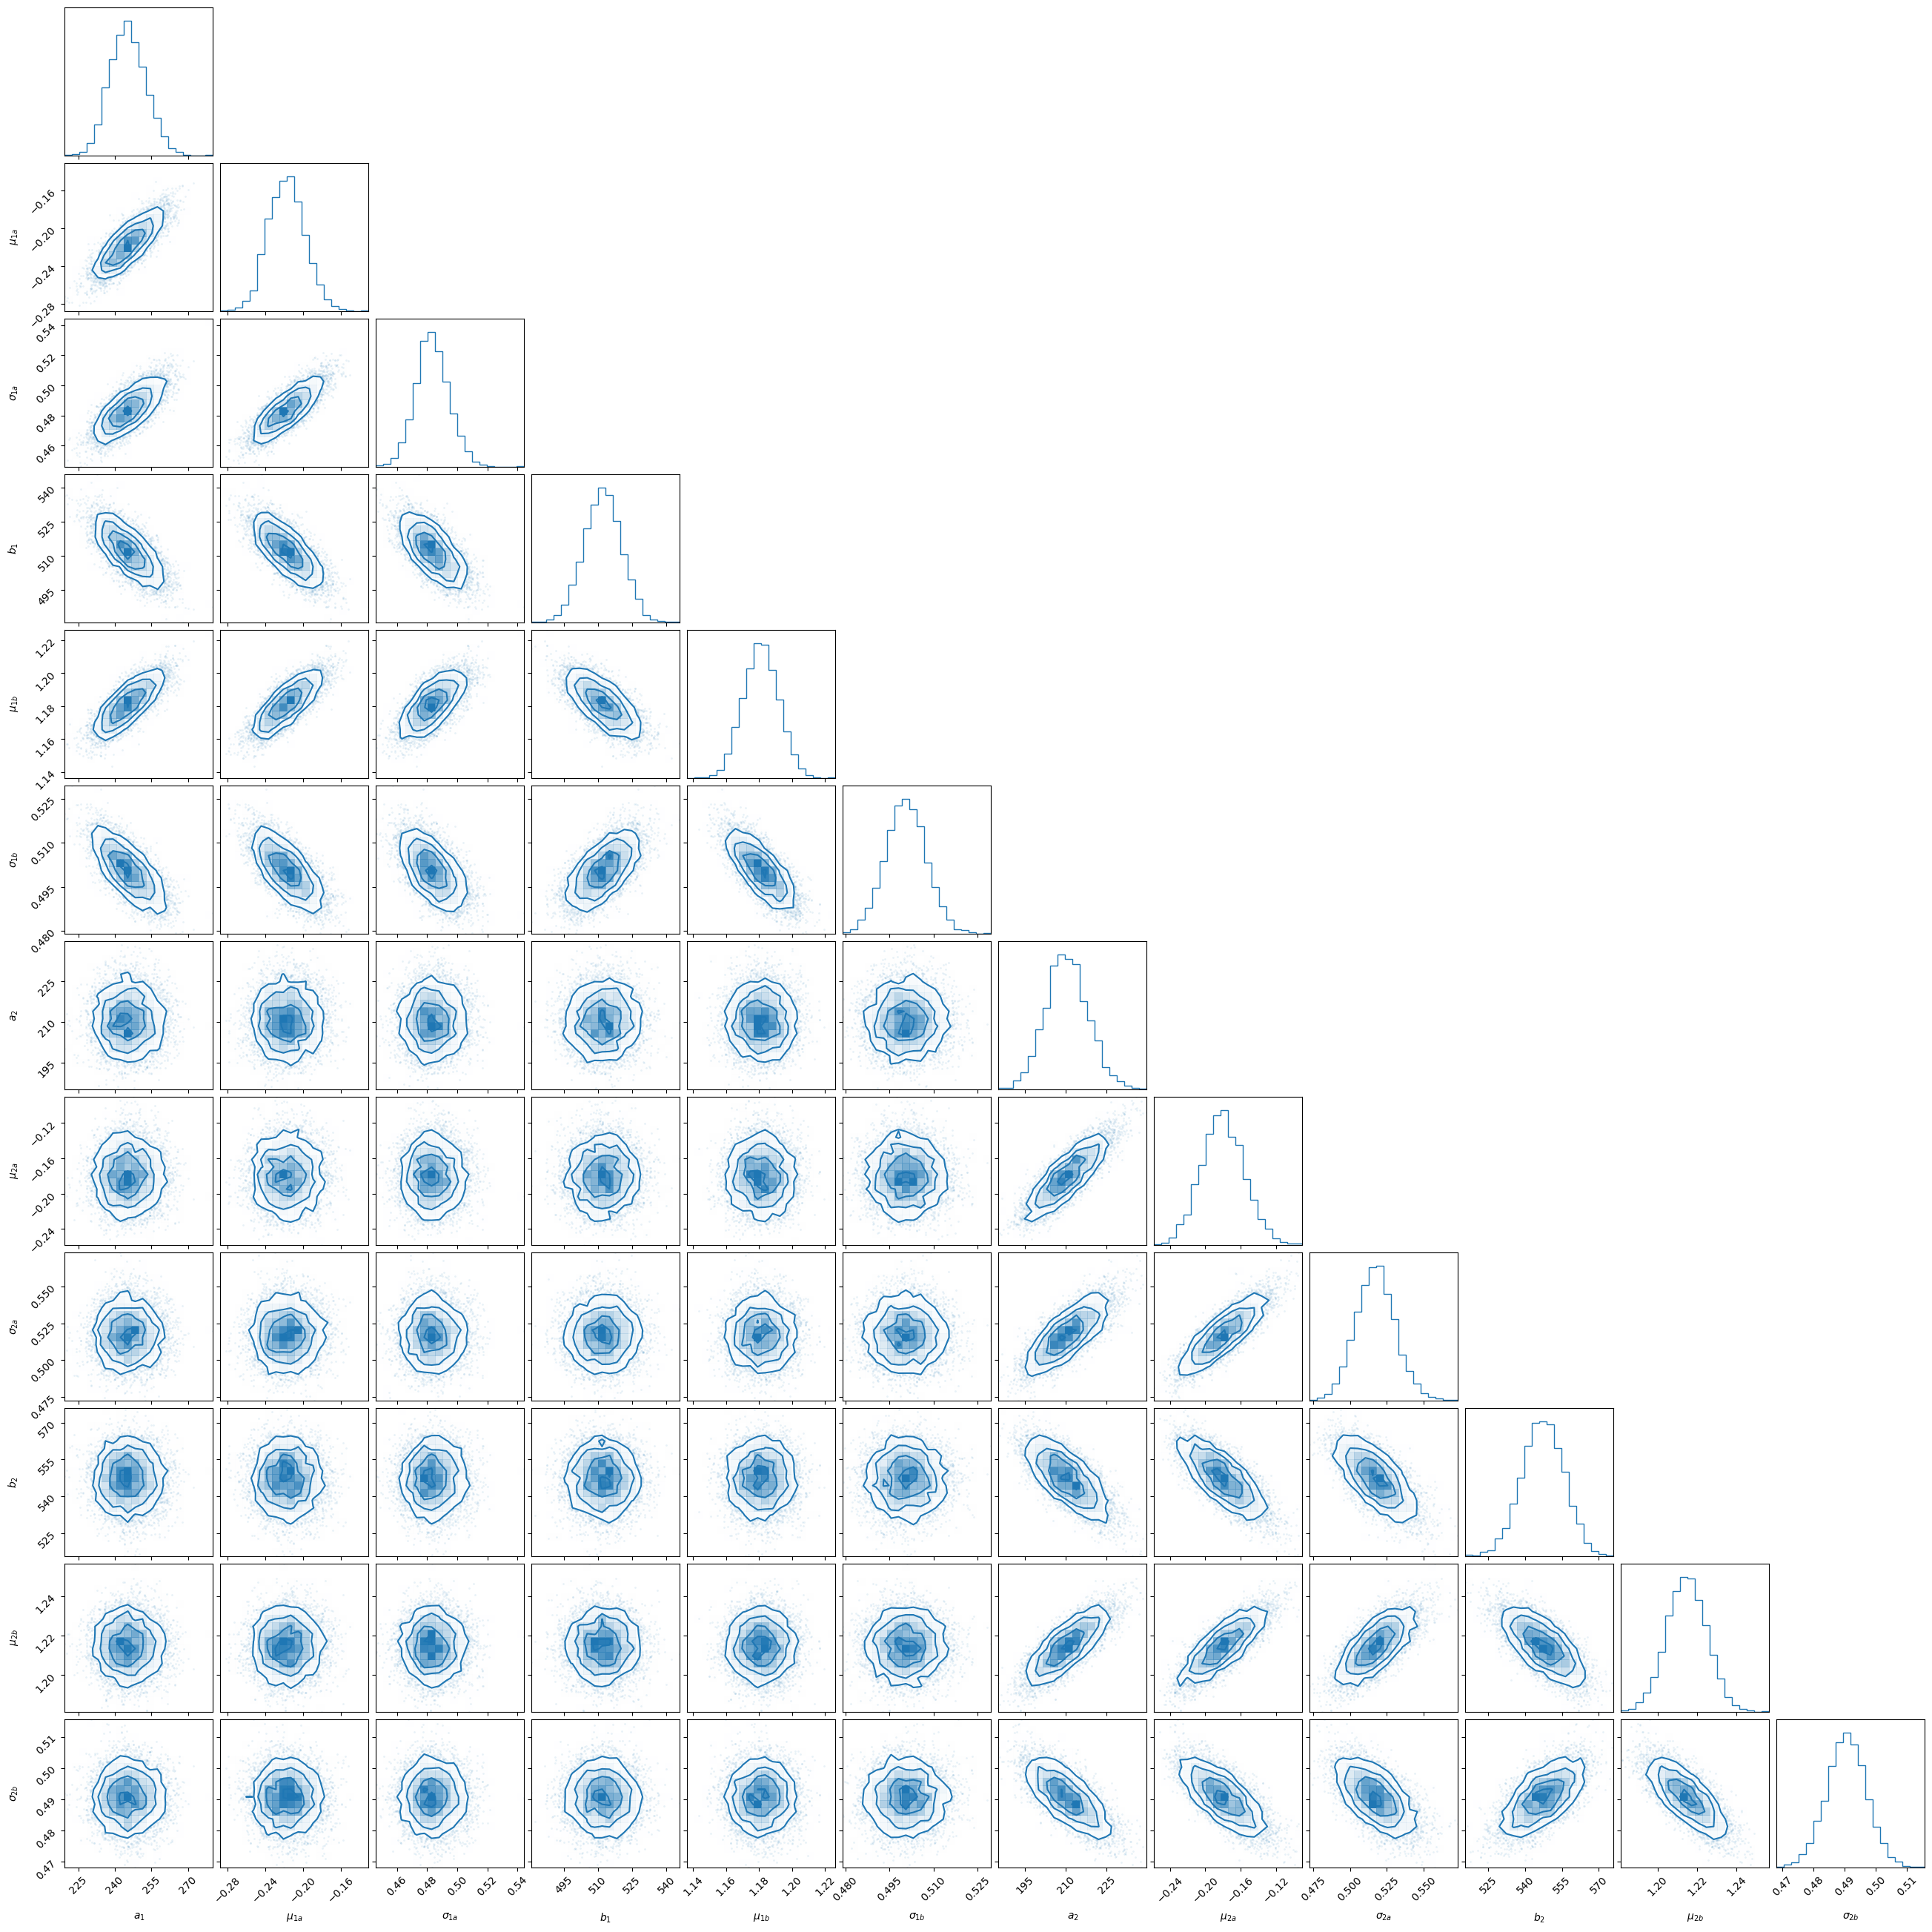

In [113]:

samples2, weights2, logl2, logp2 = sampler2.posterior()

fig = corner.corner(samples2, weights=weights2, labels=labels2_bi, color='C0')
plt.show()

In [111]:

# VF log(z)
lnzM2 = results2['logz'][-1]

In [112]:


#-------------------------------------------------------------------------------
# Calculate Bayes factor
#-------------------------------------------------------------------------------
lnB12 = lnzM1 - lnzM2

B12 = np.exp(lnB12)

print('B12 = {:.3g}; log(B12) = {:.3f}'.format(B12, lnB12*np.log10(np.exp(1))))
#-------------------------------------------------------------------------------


B12 = 1.74e-19; log(B12) = -18.758


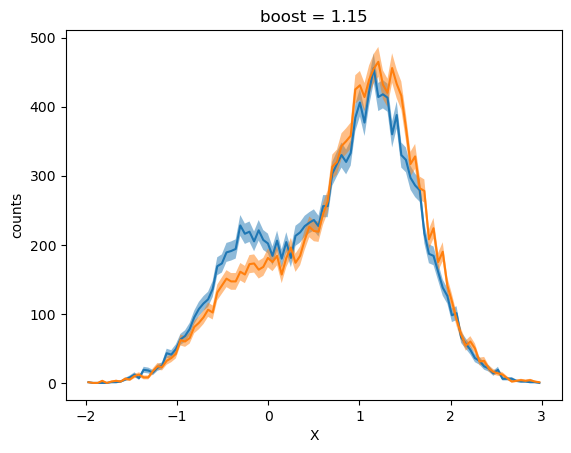

In [24]:
# plot the data
plot_x, plot_y = np.histogram(bim_small_1, bins = np.linspace(-2,3,100))[::-1]
plot_x = plot_x[:-1]+np.diff(plot_x)/2
plt.plot(plot_x, plot_y)
plt.fill_between(plot_x, plot_y+np.sqrt(plot_y), plot_y-np.sqrt(plot_y), alpha=.5)

plot_x, plot_y = np.histogram(bim_small_2, bins = np.linspace(-2,3,100))[::-1]
plot_x = plot_x[:-1]+np.diff(plot_x)/2
plt.plot(plot_x, plot_y)
plt.fill_between(plot_x, plot_y+np.sqrt(plot_y), plot_y-np.sqrt(plot_y), alpha=.5)

plt.title('boost = 1.15')
plt.ylabel('counts')
plt.xlabel('X')

plt.show()


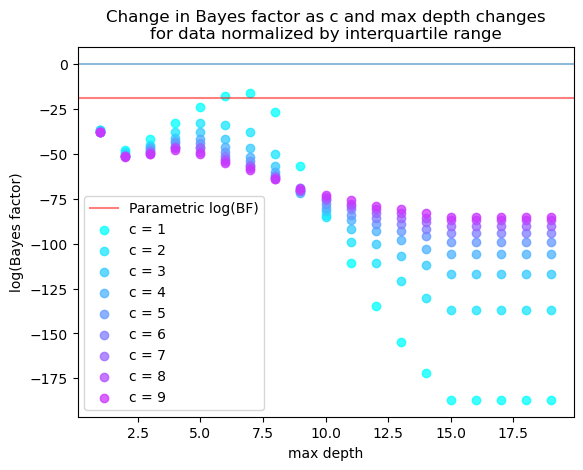

In [25]:
plt.axhline(0,alpha=.5)

plt.axhline(-18.758, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(bim_small_1, bim_small_2, c=c, max_depth=depth, log_BF=True)
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by interquartile range');

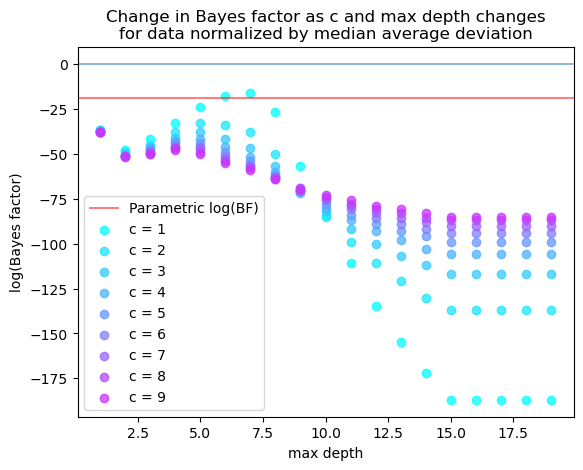

In [26]:
plt.axhline(0,alpha=.5)

plt.axhline(-18.758, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(bim_small_1, bim_small_2, c=c, max_depth=depth, log_BF=True, scale_method='mad')
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by median average deviation');

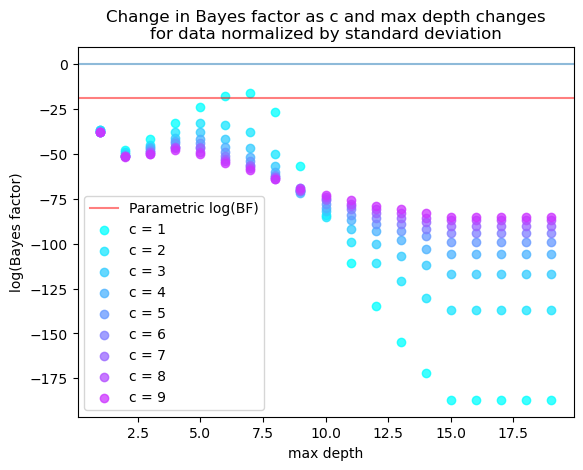

In [27]:
plt.axhline(0,alpha=.5)

plt.axhline(-18.758, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(bim_small_1, bim_small_2, c=c, max_depth=depth, log_BF=True, scale_method='std')
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by standard deviation');

## Bimodal Distribution wiht x10 more data points

In [28]:
# generate data sets
np.random.seed(0)
size=100000
bim_small_1 = bimodal_data(size,1.)
bim_small_2 = bimodal_data(size,1.05)

In [29]:
# Bins of data
bins = np.linspace(-2,3,100)
x = (bins[:-1] + bins[1:])/2
n1 = np.histogram(bim_small_1, bins = bins)[0]
dn1 = np.sqrt(n1)
n2 = np.histogram(bim_small_2, bins = bins)[0]
dn2 = np.sqrt(n2)

In [25]:
#-------------------------------------------------------------------------------
# 1-parent model
#-------------------------------------------------------------------------------
fit_bounds1 = [
                  [2000, 5000],  # a ........ Gaussian a amplitude
                  [-1, 1],  # mu_a ..... Gaussian a location
                  [0.1, 1.],     # sigma_a .. Gaussian a scale
                  [4000, 8000],  # b ........ Gaussian a amplitude
                  [0, 2],  # mu_b ..... Gaussian a location
                  [0.1, 1.],     # sigma_b .. Gaussian a scale
              ]

prior = pc.Prior([
    uniform(x[0], x[1] - x[0]) for x in fit_bounds1
])

# Prior samples for M1
prior_samples1 = np.random.uniform(low=np.array(fit_bounds1).T[0], 
                                      high=np.array(fit_bounds1).T[1], 
                                      size=(n_particles, n_dim1_bi))



with Pool(n_cpus) as pool:

    # Initialize sampler for M1
    sampler1 = pc.Sampler(n_ess=n_particles, 
                             n_dim=n_dim1_bi, 
                             likelihood=logLjoint1_norm, 
                             prior=prior, 
                             #bounds=np.array(fit_bounds1), 
                             likelihood_args=[n1, n2, x, 2], 
                             #prior_args=[np.array(fit_bounds1)], 
                             pool=pool)

    # Run sampler
    sampler1.run()#prior_samples1)
        
# Get results
results1 = sampler1.results


Iter: 88it [09:09,  6.25s/it, calls=36750, beta=1, logZ=-1.06e+3, ESS=5.02e+3, acc=0.844, steps=3, logP=-1.05e+3, eff=1]   


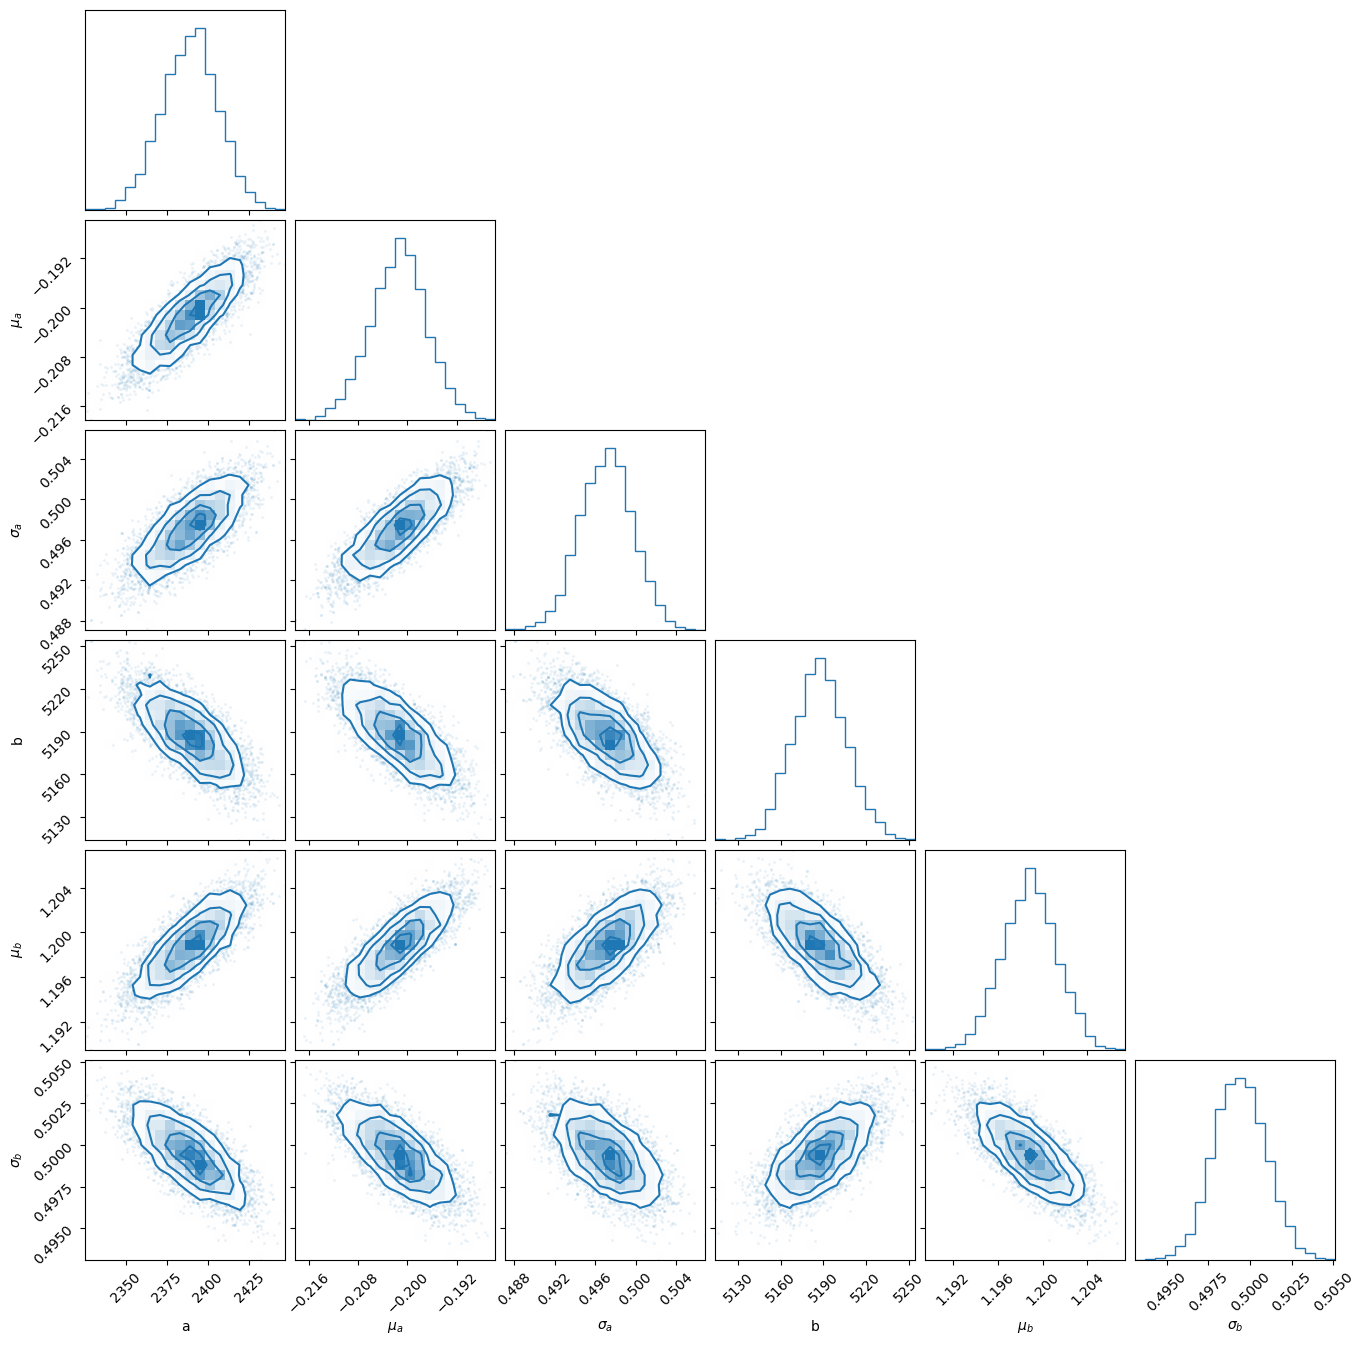

In [26]:

samples1, weights1, logl1, logp1 = sampler1.posterior()

fig = corner.corner(samples1, weights=weights1, labels=labels1_bi, color='C0')
plt.show()

In [27]:
# log(z)
lnzM1 = results1['logz'][-1]

In [28]:

#-------------------------------------------------------------------------------
# 2-parent model
#-------------------------------------------------------------------------------
fit_bounds2 = [
                  [2000, 5000],  # a1 ........ Gaussian a amplitude
                  [-1, 1],  # mu_a1 ..... Gaussian a location
                  [0.1, 1.],     # sigma_a1 .. Gaussian a scale
                  [4000, 8000],  # b1 ........ Gaussian a amplitude
                  [0, 2],  # mu_b1 ..... Gaussian a location
                  [0.1, 1.],     # sigma_b .. Gaussian a scale
                  [2000, 5000],  # a2 ........ Gaussian a amplitude
                  [-1, 1],  # mu_a2 ..... Gaussian a location
                  [0.1, 1.],     # sigma_a2 .. Gaussian a scale
                  [4000, 8000],  # b2 ........ Gaussian a amplitude
                  [0, 2],  # mu_b2 ..... Gaussian a location
                  [0.1, 1.],     # sigma_b2 .. Gaussian a scale
              ]

prior = pc.Prior([
    uniform(x[0], x[1] - x[0]) for x in fit_bounds2
])

# Prior samples for M2
prior_samples2 = np.random.uniform(low=np.array(fit_bounds2).T[0], 
                                      high=np.array(fit_bounds2).T[1], 
                                      size=(n_particles, n_dim2_bi))



with Pool(n_cpus) as pool:

    # Initialize sampler for M1
    sampler2 = pc.Sampler(n_ess=n_particles, 
                             n_dim=n_dim2_bi, 
                             likelihood=logLjoint2_norm, 
                             prior=prior, 
                             #bounds=np.array(fit_bounds2), 
                             likelihood_args=[n1, n2, x, 2], 
                             #log_prior_args=[np.array(fit_bounds2)], 
                             pool=pool)

    # Run sampler
    sampler2.run()#prior_samples2)
        
# Get results
results2 = sampler2.results

################################################################################



Iter: 114it [10:22,  5.46s/it, calls=115250, beta=1, logZ=-952, ESS=5.12e+3, acc=0.785, steps=3, logP=-931, eff=1]          


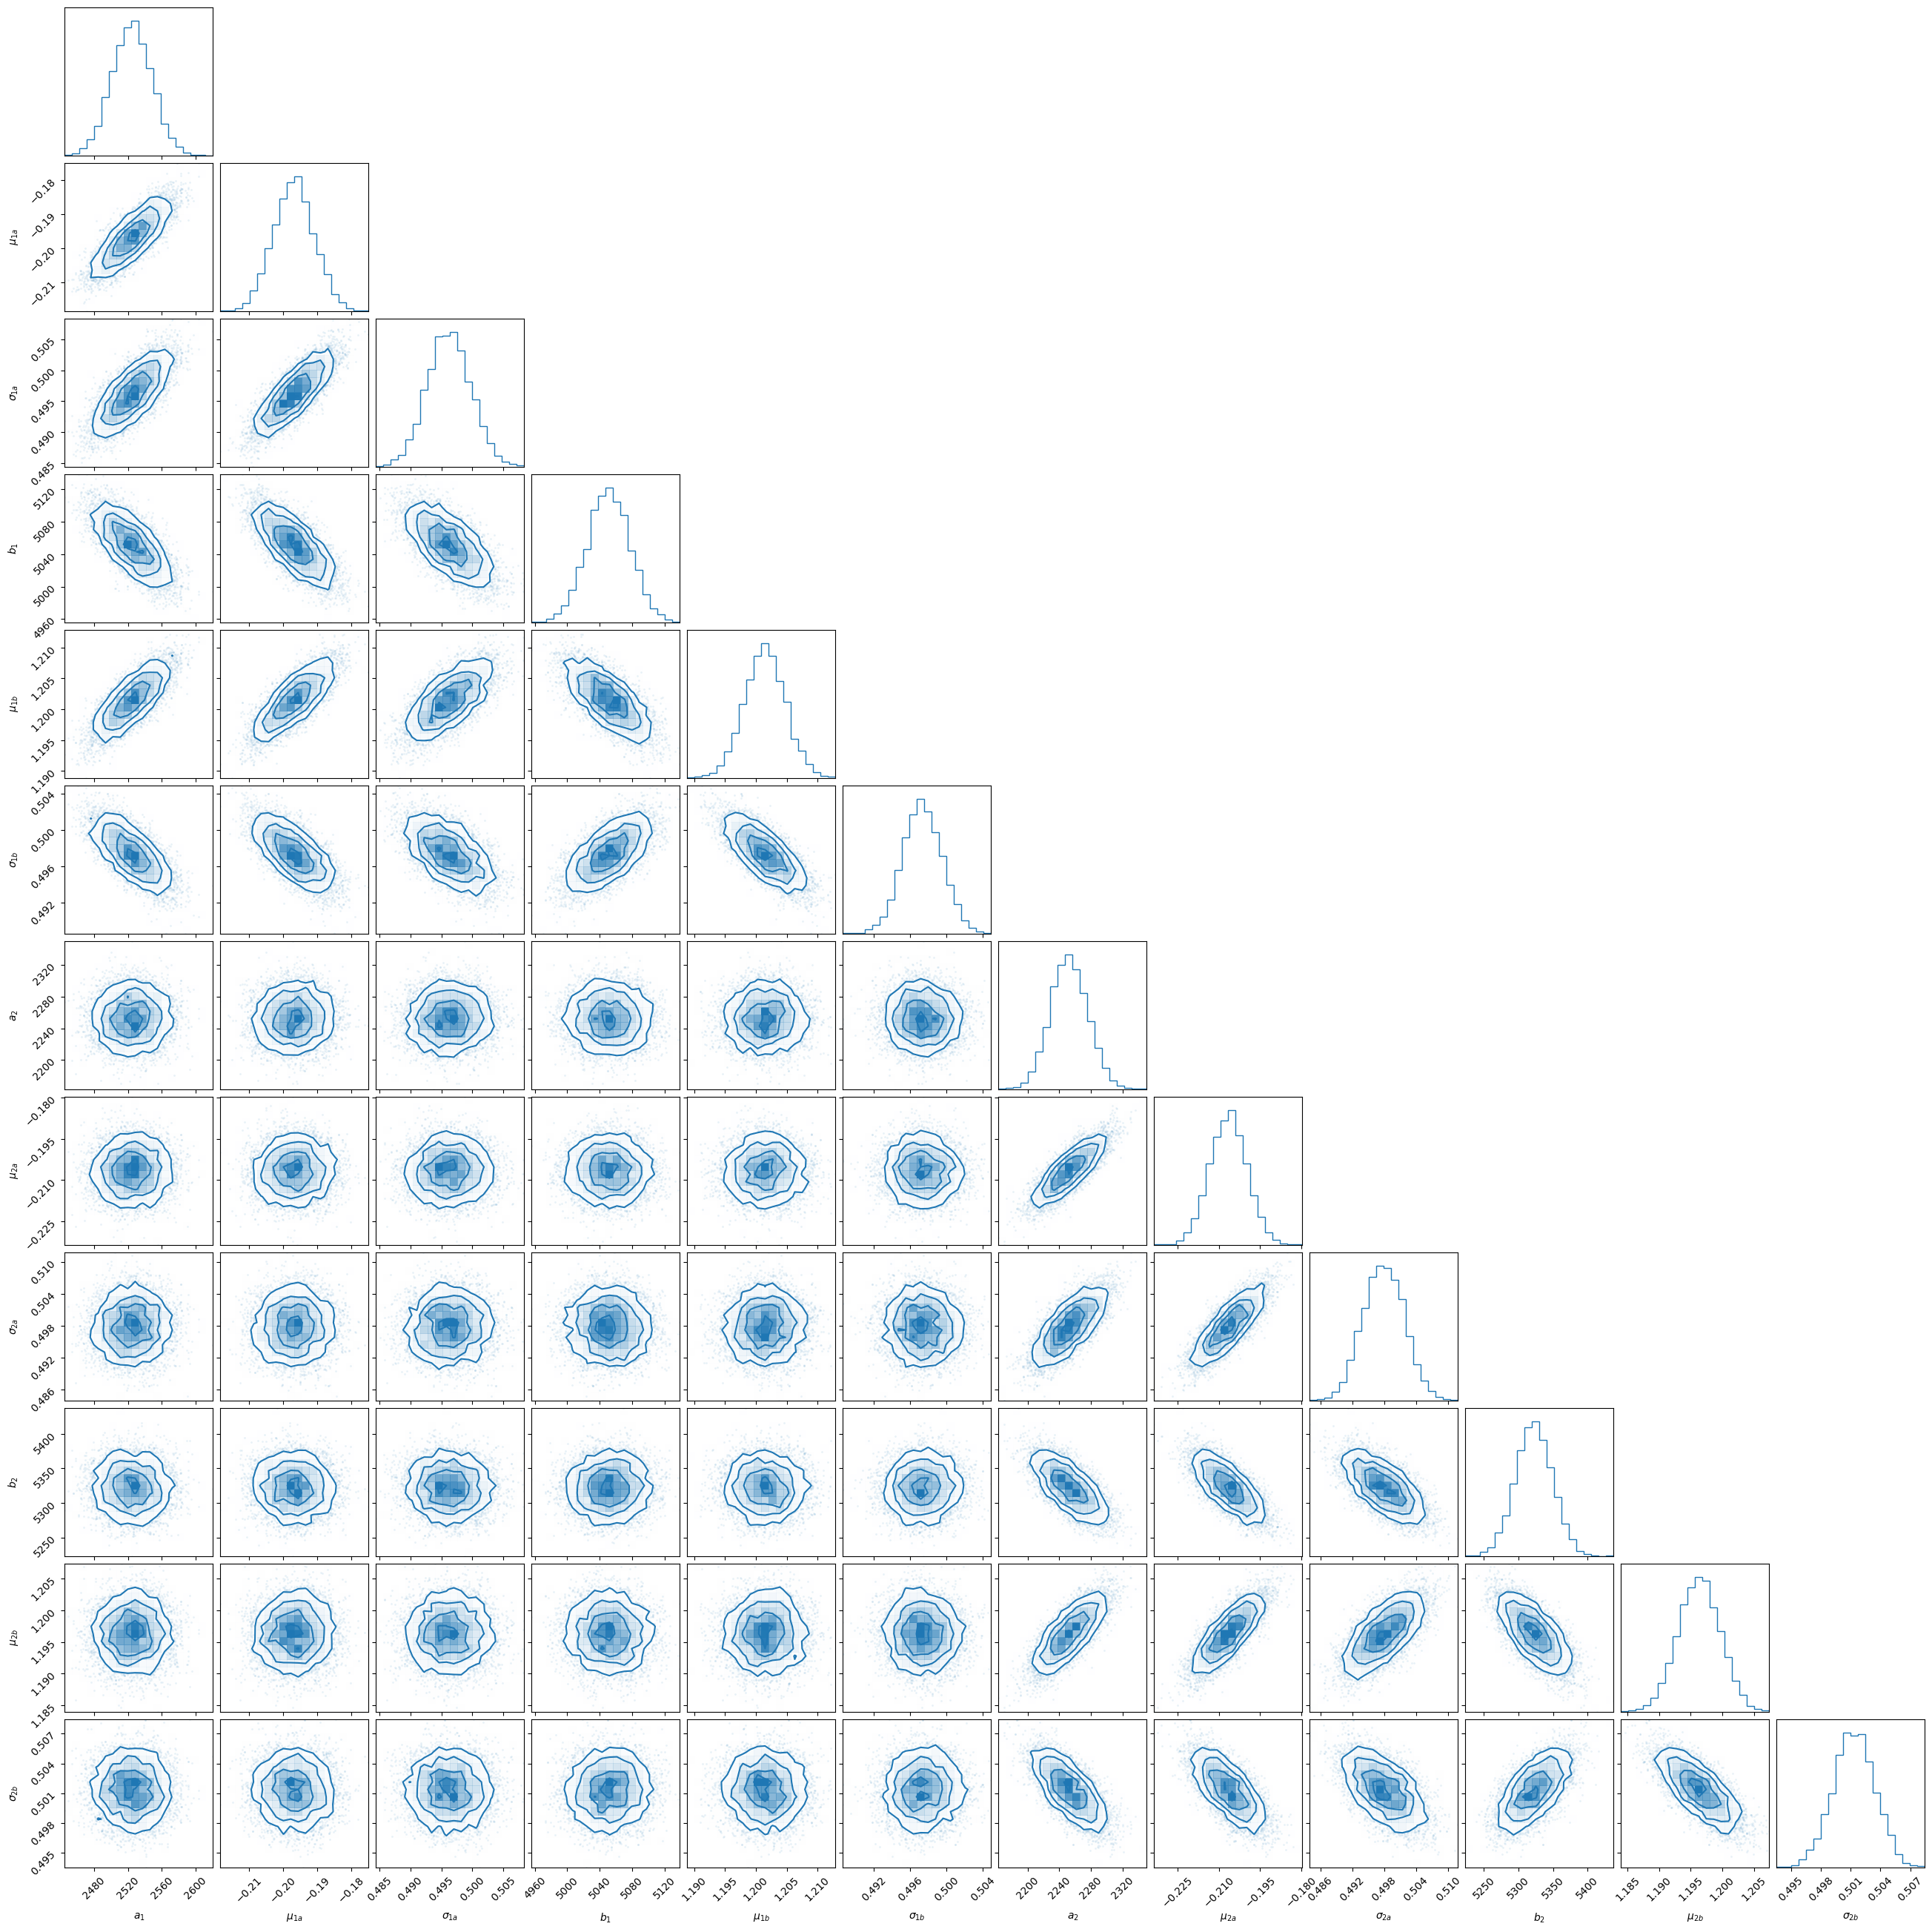

In [29]:

samples2, weights2, logl2, logp2 = sampler2.posterior()

fig = corner.corner(samples2, weights=weights2, labels=labels2_bi, color='C0')
plt.show()

In [30]:

# VF log(z)
lnzM2 = results2['logz'][-1]

In [31]:


#-------------------------------------------------------------------------------
# Calculate Bayes factor
#-------------------------------------------------------------------------------
lnB12 = lnzM1 - lnzM2

B12 = np.exp(lnB12)

print('B12 = {:.3g}; log(B12) = {:.3f}'.format(B12, lnB12*np.log10(np.exp(1))))
#-------------------------------------------------------------------------------


B12 = 3.67e-48; log(B12) = -47.435


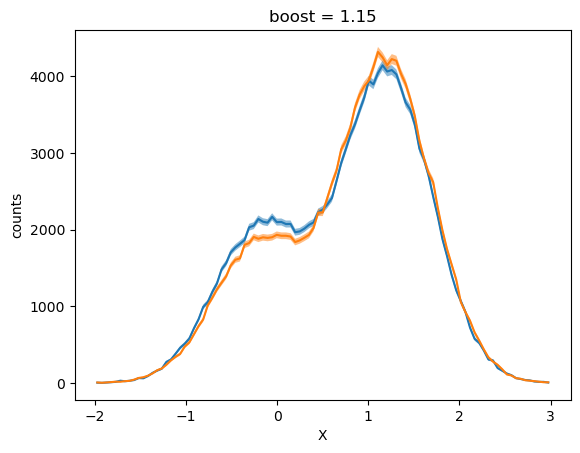

In [30]:
#plot the data
plot_x, plot_y = np.histogram(bim_small_1, bins = np.linspace(-2,3,100))[::-1]
plot_x = plot_x[:-1]+np.diff(plot_x)/2
plt.plot(plot_x, plot_y)
plt.fill_between(plot_x, plot_y+np.sqrt(plot_y), plot_y-np.sqrt(plot_y), alpha=.5)

plot_x, plot_y = np.histogram(bim_small_2, bins = np.linspace(-2,3,100))[::-1]
plot_x = plot_x[:-1]+np.diff(plot_x)/2
plt.plot(plot_x, plot_y)
plt.fill_between(plot_x, plot_y+np.sqrt(plot_y), plot_y-np.sqrt(plot_y), alpha=.5)

plt.title('boost = 1.15')
plt.ylabel('counts')
plt.xlabel('X')

plt.show()


In [33]:
#plt.scatter(x, model_norm([2000, -.2, .5], x)+model_norm([4000, 1.2, .5], x))
#plt.scatter(x, model_norm([5000, -.2, .5], x)+model_norm([8000, 1.2, .5], x))

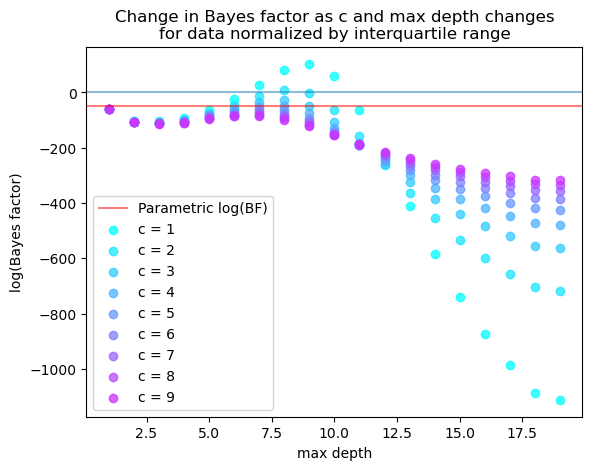

In [31]:
plt.axhline(0,alpha=.5)

plt.axhline(-47.435, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(bim_small_1, bim_small_2, c=c, max_depth=depth, log_BF=True)
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by interquartile range');

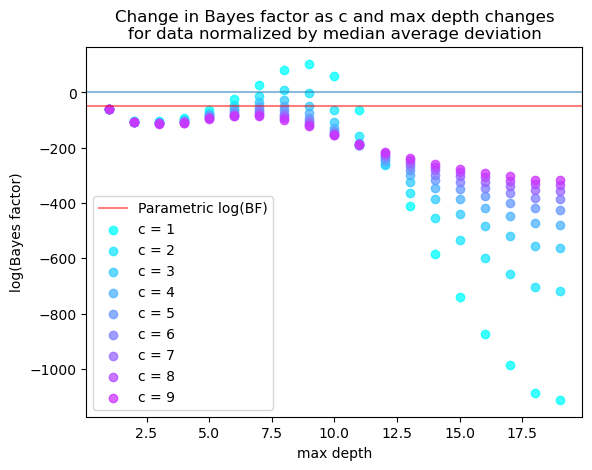

In [32]:
plt.axhline(0,alpha=.5)

plt.axhline(-47.435, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(bim_small_1, bim_small_2, c=c, max_depth=depth, log_BF=True, scale_method='mad')
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by median average deviation');

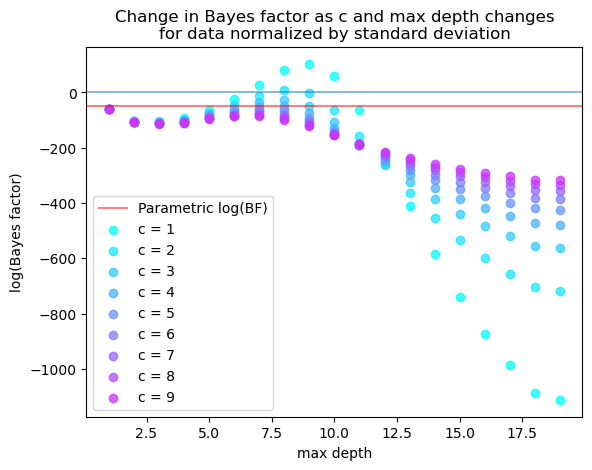

In [33]:
plt.axhline(0,alpha=.5)

plt.axhline(-47.435, alpha=.5, color='red', label='Parametric log(BF)')

for i, c in enumerate(range(1,10)):
    rgba = cmap(i/10)
    
    # create samples from a gaussian distribution with mu = 0
    
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    depth_array = np.arange(1,20)
    log_bayes_factors = np.zeros_like(depth_array)
    for i, depth in enumerate(depth_array):
        
        log_bayes_factors[i] = get_bayes_factor(bim_small_1, bim_small_2, c=c, max_depth=depth, log_BF=True, scale_method='std')
    plt.scatter(depth_array, log_bayes_factors,label=f'c = {c}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('max depth')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as c and max depth changes\nfor data normalized by standard deviation');

# How does the Bayes Factor vary as a function of the difference in distributions? And as a function of the algorithm parameters?

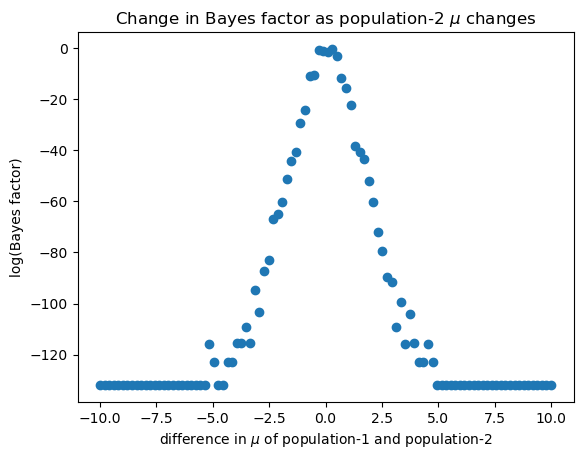

In [34]:
# vary mu

# create samples from a gaussian distribution with mu = 0
population_1 = np.random.normal (loc = 0, scale = 1, size=100)

# create samples from a gaussian distribution with varying mu (population_2), 
# and observe how the Bayes factors change when comparing with population_1
mu_array = np.linspace(-10,10,100)
log_bayes_factors = np.zeros_like(mu_array)
for i, mu in enumerate(mu_array):
    population_2 = np.random.normal (loc = mu, scale = 1, size=100)

    log_bayes_factors[i] = get_bayes_factor(population_1, population_2, log_BF=True)

plt.scatter(mu_array, log_bayes_factors)
plt.xlabel('difference in $\\mu$ of population-1 and population-2')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as population-2 $\\mu$ changes');

In [ ]:
# differnet std (1 vs 0.9), vary tree depth
for i, max_depth in enumerate(range(1,10)):
    rgba = cmap(i/10)
    # create samples from a gaussian distribution with mu = 0
    population_1 = np.random.normal (loc = 0, scale = 1, size=1000)
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    mu_array = np.linspace(-10,10,100)
    log_bayes_factors = np.zeros_like(mu_array)
    for i, mu in enumerate(mu_array):
        population_2 = np.random.normal (loc = mu, scale = 0.9, size=1000)
    
        log_bayes_factors[i] = pt_d_sample_test(population_1, population_2, max_depth=max_depth, log_BF=True)
    plt.scatter(mu_array, log_bayes_factors,label=f'm = {max_depth}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('difference in $\\mu$ of population-1 and population-2')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as population-2 $\\mu$ changes');

In [ ]:
# same std, vary tree depth
for i, max_depth in enumerate(range(1,10)):
    rgba = cmap(i/10)
    # create samples from a gaussian distribution with mu = 0
    population_1 = np.random.normal (loc = 0, scale = 1, size=1000)
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    mu_array = np.linspace(-10,10,100)
    log_bayes_factors = np.zeros_like(mu_array)
    for i, mu in enumerate(mu_array):
        population_2 = np.random.normal (loc = mu, scale = 1, size=1000)
    
        log_bayes_factors[i] = pt_d_sample_test(population_1, population_2, max_depth=max_depth, log_BF=True)
    plt.scatter(mu_array, log_bayes_factors,label=f'm = {max_depth}', color=rgba, alpha = .75)
plt.legend()
plt.xlabel('difference in $\\mu$ of population-1 and population-2')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as population-2 $\\mu$ changes');

In [ ]:
# vary population size
for size in (10, 100, 1000, 10000):
    # create samples from a gaussian distribution with mu = 0
    population_1 = np.random.normal (loc = 0, scale = 1, size=size)
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    mu_array = np.linspace(-10,10,100)
    log_bayes_factors = np.zeros_like(mu_array)
    for i, mu in enumerate(mu_array):
        population_2 = np.random.normal (loc = mu, scale = 1, size=size)
    
        log_bayes_factors[i] = pt_d_sample_test(population_1, population_2, log_BF=True)
    plt.scatter(mu_array, log_bayes_factors,label=f'size = {size}')
plt.legend()
plt.xlabel('difference in $\\mu$ of population-1 and population-2')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as population-2 $\\mu$ changes');

In [ ]:
# vary praction of points in sample_1 and sample_2 ()
for frac in (.1, .2, .3, .5):
    # create samples from a gaussian distribution with mu = 0
    size = 1000
    population_1 = np.random.normal (loc = 0, scale = 1, size=int(size*frac))
    
    # create samples from a gaussian distribution with varying mu (population_2), 
    # and observe how the Bayes factors change when comparing with population_1
    mu_array = np.linspace(-10,10,100)
    log_bayes_factors = np.zeros_like(mu_array)
    for i, mu in enumerate(mu_array):
        population_2 = np.random.normal (loc = mu, scale = 1, size=int(size*(1-frac)))
    
        log_bayes_factors[i] = pt_d_sample_test(population_1, population_2, log_BF=True)
    plt.scatter(mu_array, log_bayes_factors,label=f'void frac = {frac:.1g}')
plt.legend()
plt.xlabel('difference in $\\mu$ of population-1 and population-2')
plt.ylabel('log(Bayes factor)')
plt.title('Change in Bayes factor as population-2 $\\mu$ changes');